<a href="https://colab.research.google.com/github/BenxiaHu/DeepLearning/blob/main/Alphagenome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
#%pip install alphagenome
from alphagenome.data import genome
from alphagenome.models import dna_client
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
from alphagenome.data import gene_annotation
from alphagenome.data import transcript as transcript_utils

In [6]:
API_KEY = 'KEY'
model = dna_client.create(API_KEY)

In [26]:
chrom = 'chr2'
pos   = 127133851
win = 2**17
centered = genome.Interval(chromosome=chrom, start=pos-1, end=pos+1)
interval = centered.resize(win)
ref, alt = 'C', 'A'
variant = genome.Variant(chromosome=chrom, position=pos,
                         reference_bases=ref, alternate_bases=alt)


In [25]:
outputs = model.predict_variant(
    interval=interval,
    variant=variant,
    ontology_terms=['UBERON:0000955'],
    requested_outputs=[dna_client.OutputType.DNASE,
        dna_client.OutputType.ATAC,
        dna_client.OutputType.CHIP_TF,        # TF ChIP(-seq) binding
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.CAGE,
        dna_client.OutputType.PROCAP,
        dna_client.OutputType.CHIP_HISTONE,   # histone modifications],
    ]
)


In [29]:
plot_iv = outputs.reference.rna_seq.interval.resize(2**15) \
          if hasattr(outputs.reference, "rna_seq") \
          else outputs.reference.dnase.interval.resize(2**15)

In [45]:
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_longest_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)
longest_transcripts = transcript_extractor.extract(interval)

In [48]:
panels = [
    plot_components.TranscriptAnnotation(longest_transcripts),
    plot_components.OverlaidTracks(
        tdata={'REF': outputs.reference.dnase,
               'ALT': outputs.alternate.dnase},
        colors={'REF': 'blue', 'ALT': 'red'},
    ),

    plot_components.OverlaidTracks(
        tdata={'REF': outputs.reference.atac,
               'ALT': outputs.alternate.atac},
        colors={'REF': 'blue', 'ALT': 'red'},
    ),

    plot_components.OverlaidTracks(
        tdata={'REF': outputs.reference.chip_tf,
               'ALT': outputs.alternate.chip_tf},
        colors={'REF': 'blue', 'ALT': 'red'},
    ),

    plot_components.OverlaidTracks(
        tdata={'REF': outputs.reference.rna_seq,
               'ALT': outputs.alternate.rna_seq},
        colors={'REF': 'blue', 'ALT': 'red'},
    ),

    plot_components.OverlaidTracks(
        tdata={'REF': outputs.reference.cage,
               'ALT': outputs.alternate.cage},
        colors={'REF': 'blue', 'ALT': 'red'},
    ),

    plot_components.OverlaidTracks(
        tdata={'REF': outputs.reference.procap,
               'ALT': outputs.alternate.procap},
        colors={'REF': 'blue', 'ALT': 'red'},
    ),

    plot_components.OverlaidTracks(
        tdata={'REF': outputs.reference.chip_histone,
               'ALT': outputs.alternate.chip_histone},
        colors={'REF': 'blue', 'ALT': 'red'},
    ),
]


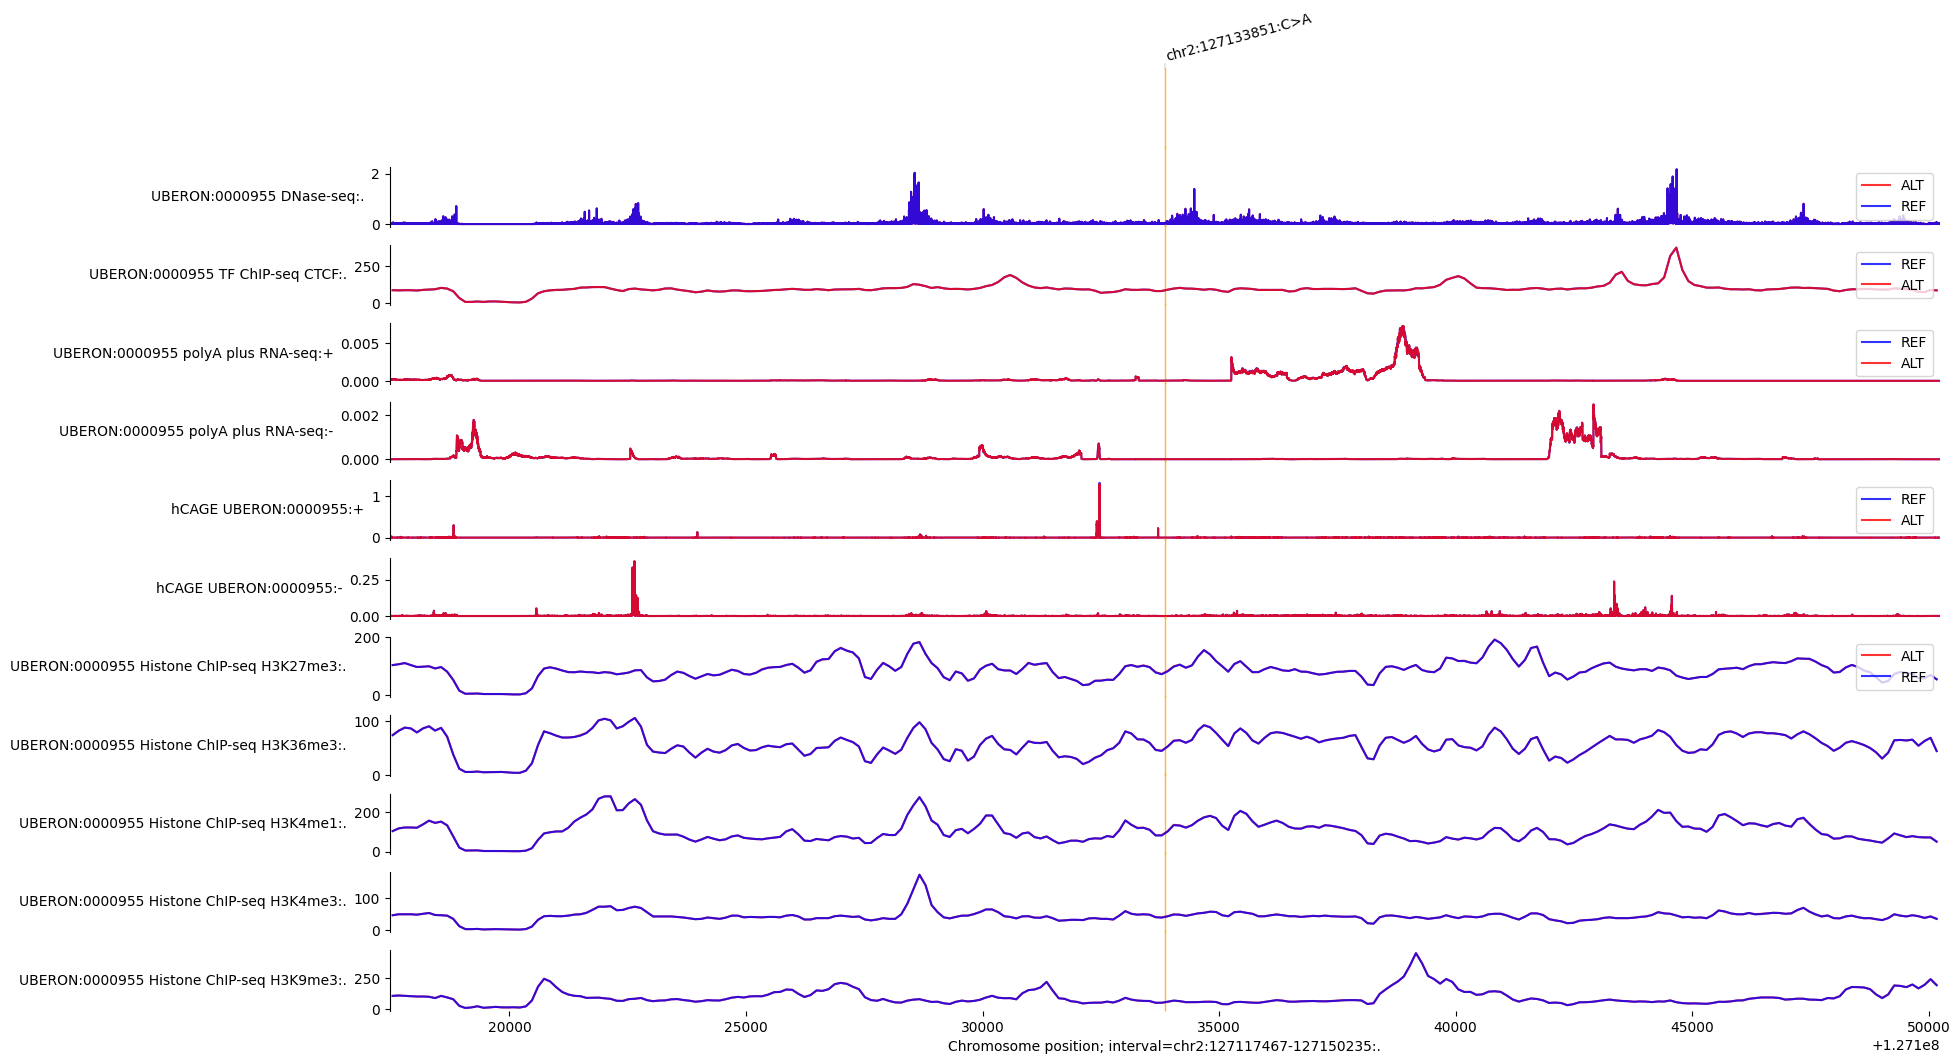

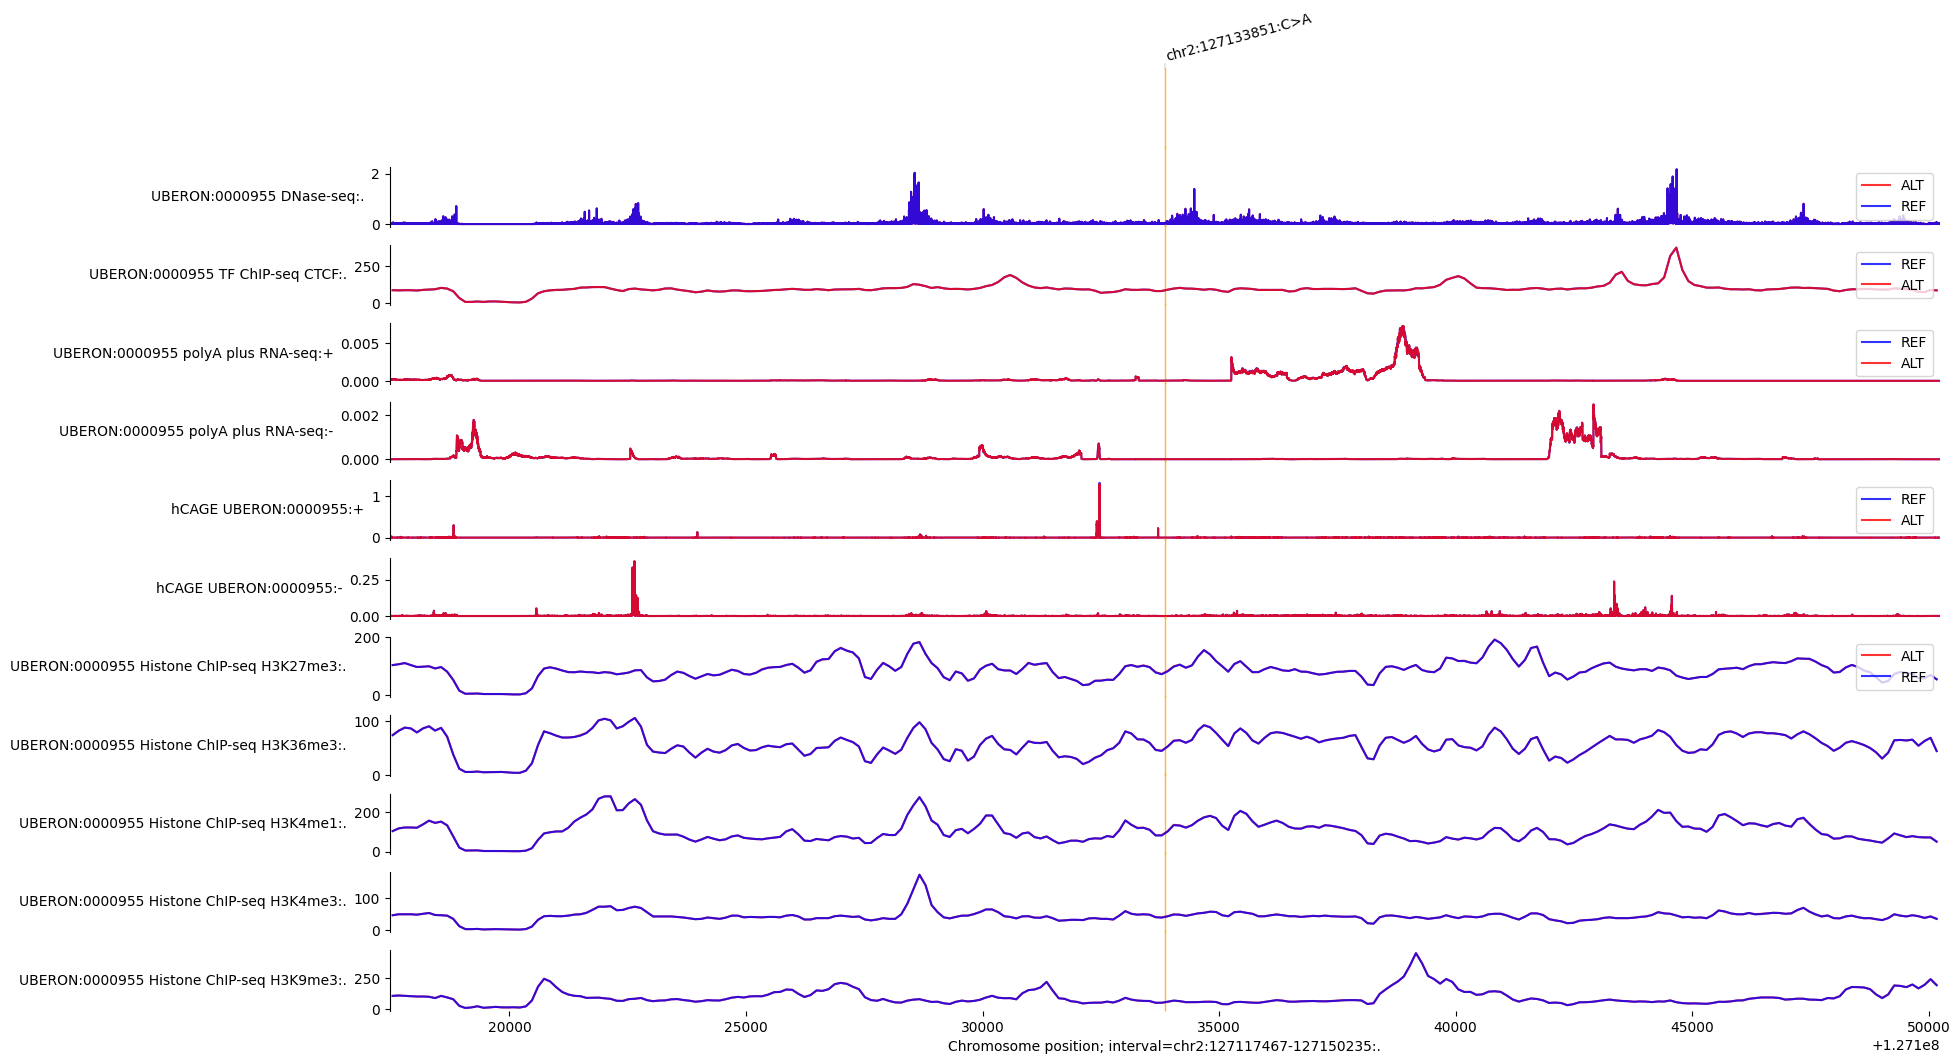

In [49]:
plot_components.plot(
    panels,
    interval=plot_iv,
    annotations=[plot_components.VariantAnnotation([variant], alpha=0.8)],
)

In [10]:
plt.show()